In [16]:
import os
from pathlib import Path
from pprint import pformat

import requests
import yfinance as yf
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import Tool
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition


In [17]:
def lookup_stock_symbol(company_name: str) -> str:
    """
    Converts a company name to its stock symbol using a financial API.

    Parameters:
        company_name (str): The full company name (e.g., 'Tesla').

    Returns:
        str: The stock symbol (e.g., 'TSLA') or an error message.
    """
    api_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": "4CB8FGQ3W6VL4X49",
    }
    response = requests.get(api_url, params=params)
    data = response.json()
    # print(f"Stock data : {data}")

    if "bestMatches" in data and data["bestMatches"]:
        symbol = data["bestMatches"][0]["1. symbol"]
        print(f"symbol : {symbol}")
        return data["bestMatches"][0]["1. symbol"]
    else:
        return f"Symbol not found for {company_name}."


def fetch_stock_data_raw(stock_symbol: str) -> dict:
    """
    Fetches comprehensive stock data for a given symbol and returns it as a combined dictionary.

    Parameters:
        stock_symbol (str): The stock ticker symbol (e.g., 'TSLA').
        period (str): The period to analyze (e.g., '1mo', '3mo', '1y').

    Returns:
        dict: A dictionary combining general stock info and historical market data.
    """
    period = "1mo"
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        stock_info = stock.info
        # Historical OHLCV data
        stock_history = stock.history(period=period).to_dict()

        # Combine both into a single dictionary
        combined_data = {
            "stock_symbol": stock_symbol,
            "info": stock_info,
            "history": stock_history,
        }

        return pformat(combined_data)
    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}


In [18]:
# System message
assistant_system_message = SystemMessage(
    content=(
        """
            You are a professional financial assistant specializing in stock market analysis and investment strategies. 
            Your role is to analyze stock data and provide **clear, decisive recommendations** that users can act on, 
            whether they already hold the stock or are considering investing.

            You have access to a set of tools that can provide the data you need to analyze stocks effectively. 
            Use these tools to gather relevant information such as stock symbols, current prices, historical trends, 
            and key financial indicators. Your goal is to leverage these resources efficiently to generate accurate, 
            actionable insights for the user.

            Your responses should be:
            - **Concise and direct**, summarizing only the most critical insights.
            - **Actionable**, offering clear guidance on whether to buy, sell, hold, or wait for better opportunities.
            - **Context-aware**, considering both current holders and potential investors.
            - **Free of speculation**, relying solely on factual data and trends.

            ### Response Format:
            1. **Recommendation:** Buy, Sell, Hold, or Wait.
            2. **Key Insights:** Highlight critical trends and market factors that influence the decision.
            3. **Suggested Next Steps:** What the user should do based on their current position.
from IPython.display import Image, display
            If the user does not specify whether they own the stock, provide recommendations for both potential buyers and current holders. Ensure your advice considers valuation, trends, and market sentiment.

            Your goal is to help users make informed financial decisions quickly and confidently.
        """
    )
)


In [19]:
PROJECT_ROOT = Path.cwd().parent
load_dotenv(PROJECT_ROOT / ".env")

GROQ_API_KEY = os.getenv("GROQ_API_KEY_DEFAULT")


In [20]:
# Initialize Groq LLM
llm = ChatGroq(
    api_key=GROQ_API_KEY, model_name="moonshotai/kimi-k2-instruct-0905", temperature=0.7
)


In [21]:
# Create tool bindings with additional attributes
lookup_stock = Tool.from_function(
    func=lookup_stock_symbol,
    name="lookup_stock_symbol",
    description="Converts a company name to its stock symbol using a financial API.",
    return_direct=False,  # Return result to be processed by LLM
)

fetch_stock = Tool.from_function(
    func=fetch_stock_data_raw,
    name="fetch_stock_data_raw",
    description="Fetches comprehensive stock data including general info and historical market data for a given stock symbol.",
    return_direct=False,
)

toolbox = [lookup_stock, fetch_stock]

llm_with_tools = llm.bind_tools(toolbox)


In [22]:
# defining the chat assistant node
def assistant(state: MessagesState):
    return {
        "messages": [
            llm_with_tools.invoke([assistant_system_message] + state["messages"])
        ]
    }


In [23]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Initialize the Inmemory saver:
memory = InMemorySaver()

# The checkpointer saves the graph snap shpt at various different endpoints(at each node basically)
react_graph = builder.compile(checkpointer=memory)


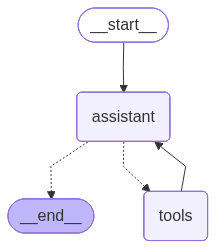

In [24]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [25]:
# messages = react_graph.invoke(
#     {"messages": [HumanMessage(content="Should I invest in Tesla stocks?")]}
# )
# for message in messages["messages"]:
#     message.pretty_print()


In [26]:
def run_financial_Advisor_with_InMemorySaver(user_req: str, thread_id, verbose=False):
    print(f"Thread_id : {thread_id}")
    config = {"configurable": {"thread_id": thread_id}}
    messages = react_graph.invoke(
        {"messages": [HumanMessage(content=user_req)]}, config=config
    )
    if verbose:
        for message in messages["messages"]:
            message.pretty_print()
    else:
        messages["messages"][-1].pretty_print()


In [27]:
run_financial_Advisor_with_InMemorySaver(
    user_req="Should I invest in Tesla stocks?", thread_id="2"
)


Thread_id : 2
symbol : 0R0X.LON
================================== Ai Message ==================================

## Tesla Stock Analysis - Investment Recommendation

**Recommendation: WAIT**

**Key Insights:**
- **Price Decline**: Tesla has fallen from $475 to $449 over the past month, showing significant downward momentum
- **High Valuation**: Trading at 207x forward earnings and 312x trailing earnings - extremely expensive even for growth stocks
- **Mixed Signals**: Analyst consensus is "Hold" with price targets ranging from $130-$600, indicating high uncertainty
- **Technical Weakness**: Stock is down 10% from its 52-week high of $498.83, suggesting selling pressure

**Suggested Next Steps:**

**For Potential Investors**: **WAIT** for a better entry point. Current valuation metrics are extremely stretched:
- Forward P/E of 207x vs. industry average of ~15x
- Price-to-Sales ratio of 15.6x is historically high
- Consider waiting for a pullback to the $350-380 range or for fundamental

In [28]:
run_financial_Advisor_with_InMemorySaver(
    user_req="what was the 52 week low price of previous stock?",
    thread_id="2",
    verbose=True,
)


Thread_id : 2
================================ Human Message =================================

Should I invest in Tesla stocks?
================================== Ai Message ==================================

I'll analyze Tesla's current stock data to provide you with a clear investment recommendation.
Tool Calls:
  lookup_stock_symbol (functions.lookup_stock_symbol:0)
 Call ID: functions.lookup_stock_symbol:0
  Args:
    __arg1: Tesla
================================= Tool Message =================================
Name: lookup_stock_symbol

0R0X.LON
================================== Ai Message ==================================

Let me fetch Tesla's comprehensive stock data to analyze the investment opportunity.
Tool Calls:
  fetch_stock_data_raw (functions.fetch_stock_data_raw:1)
 Call ID: functions.fetch_stock_data_raw:1
  Args:
    __arg1: TSLA
================================= Tool Message =================================
Name: fetch_stock_data_raw

{'history': {'Close': {Time